In [ ]:
!pip install torch

In [ ]:
!pip install --upgrade opencv-contrib-python

In [ ]:
!pip install segmentation-models-pytorch

Let's import all the libraries

In [ ]:
import torch
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

Now let's get the image files we are going to process

In [ ]:
!git clone https://github.com/parth1620/Road_seg_dataset.git

fatal: destination path 'Road_seg_dataset' already exists and is not an empty directory.


In [ ]:
import sys
sys.path.append('/content/Road_seg_dataset')

**Let's setup the configuration**

In [ ]:
CSV_FILE = '/content/Road_seg_dataset/train.csv'
DATA_DIR = '/content/Road_seg_dataset/'
DEVICE = 'cuda'

EPOCHS = 25
LR = 0.003
BATCH_SIZE = 8
IMG_SIZE = 512

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [ ]:
df = pd.read_csv(CSV_FILE)
df.head()

,images,masks
0,images/17428750_15.png,masks/17428750_15.png
1,images/23279080_15.png,masks/23279080_15.png
2,images/24179185_15.png,masks/24179185_15.png
3,images/24179035_15.png,masks/24179035_15.png
4,images/11128810_15.png,masks/11128810_15.png


In [ ]:
idx = 2

row_id = df.iloc[idx]

image_path = DATA_DIR + row_id.images
mask_path = DATA_DIR + row_id.masks

In [ ]:
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255

Lets plot the image and the mask

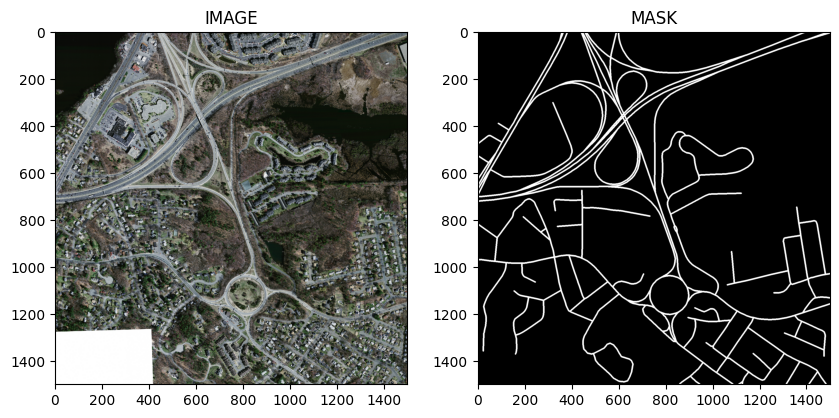

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('MASK')
ax2.imshow(mask,cmap = 'gray')

Lets spli the dataset into train and tests

In [ ]:
df_train, df_test = train_test_split(df, test_size = .20, random_state = 42)

In [ ]:
print(len(df_train), len(df_test))

159 40


# **Now lets import the Augmentation function**

For that we are going to use the albumentation function created by the https://albumentations.ai

In [ ]:
!pip install -U git+https://github.com/albumentations-team/albumentations

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-6u2u955g
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-6u2u955g
  Resolved https://github.com/albumentations-team/albumentations to commit 82818a0c4a80924d9f903a656c7f549ec6ca9cb2
  Preparing metadata (setup.py) ... done


In [ ]:
import albumentations as A

In [ ]:
def get_train_augs():
  return A.Compose([
      A.Resize(IMG_SIZE, IMG_SIZE),
      A.HorizontalFlip(p=0.5),
      A.VerticalFlip(p=0.5)
  ])

def get_test_augs():
  return A.Compose([
      A.Resize(IMG_SIZE, IMG_SIZE)
  ])

# **Now lets create custom datasets using PyTorch**

In [ ]:
from torch.utils.data import Dataset

In [ ]:
class SegmentationDataset(Dataset):

  def __init__(self, df, augmentations):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row_id = self.df.iloc[idx]

    image_path = DATA_DIR + row_id.images
    mask_path = DATA_DIR + row_id.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    #add the channel dimension to mask to add the channel dimension
    mask = np.expand_dims(mask, axis = -1)

    if self.augmentations:
      data = self.augmentations(image = image, mask = mask)
      image = data['image']
      mask = data['mask']

      #change the image and mask format from h x w x c to c x h x w

    image = np.transpose(image, (2,0,1)).astype(np.float32)
    mask = np.transpose(mask, (2,0,1)).astype(np.float32)

    image = torch.Tensor(image) / 255.0
    mask = torch.round(torch.Tensor(mask) / 255.0)

    return image, mask

In [ ]:
trainset = SegmentationDataset(df_train , get_train_augs())
testset = SegmentationDataset(df_test , get_test_augs())

In [ ]:
len(trainset)

159

In [ ]:
def show_image(image,mask,pred_image = None):

    if pred_image == None:

        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

        ax1.set_title('IMAGE')
        ax1.imshow(image.permute(1,2,0).squeeze(),cmap = 'gray')

        ax2.set_title('GROUND TRUTH')
        ax2.imshow(mask.permute(1,2,0).squeeze(),cmap = 'gray')

    elif pred_image != None :

        f, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(10,5))

        ax1.set_title('IMAGE')
        ax1.imshow(image.permute(1,2,0).squeeze(),cmap = 'gray')

        ax2.set_title('GROUND TRUTH')
        ax2.imshow(mask.permute(1,2,0).squeeze(),cmap = 'gray')

        ax3.set_title('MODEL OUTPUT')
        ax3.imshow(pred_image.permute(1,2,0).squeeze(),cmap = 'gray')

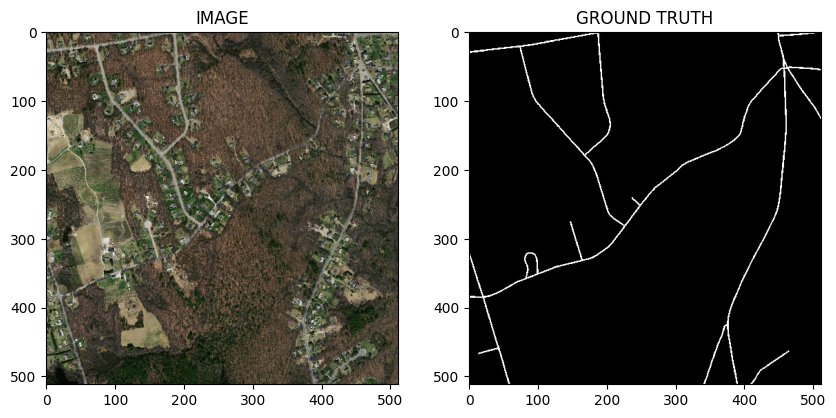

In [ ]:
idx = 69

image, mask = trainset[idx]

show_image(image,mask)

# **Lets load Datasets into batches**

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
testloader = DataLoader(trainset, batch_size = BATCH_SIZE)

In [ ]:
len(trainloader)

20

# **Now lets create the Segmentation Model**

In [ ]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

from torch import nn

In [ ]:
class SegmentationModel(nn.Module):

  def __init__(self):
    super(SegmentationModel, self).__init__()

    self.backbone = smp.Unet(
        encoder_name = ENCODER,
        encoder_weights = WEIGHTS,
        in_channels = 3,
        classes =1,
        activation = None
    )

  def forward(self, images, masks = None):

    logits = self.backbone(images)

    if masks != None:
      return logits, DiceLoss(mode = 'binary')(logits, masks) + nn.BCEWithLogitsLoss()(logits, masks)

    return logits

In [ ]:
model = SegmentationModel()
model.to(DEVICE);

# **Create the training and testing function**

In [ ]:
def train_fn(dataloader, model, optimizer):

  model.train()
  total_loss = 0.0

  for images, masks in tqdm(dataloader):
    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    optimizer.zero_grad()

    logits, loss = model(images, masks)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(dataloader)

In [ ]:
def test_fn(dataloader, model):

  model.eval()
  total_loss = 0.0

  with torch.no_grad():

    for images, masks in tqdm(dataloader):
      images = images.to(DEVICE)
      masks = masks.to(DEVICE)

      logits, loss = model(images, masks)


      total_loss += loss.item()

    return total_loss / len(dataloader)

# **Lets train the model now**

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [ ]:
best_loss = np.Inf

for i in range(EPOCHS):
  train_loss = train_fn(trainloader, model, optimizer)
  test_loss = test_fn(testloader, model)

  if test_loss < best_loss:
    torch.save(model.state_dict(), "best-model.pt")
    print(f'Model Saved')
    best_loss = test_loss

    print(f"Epoch: {i+1}, Train loss: {train_loss}, Test loss: {test_loss}")

100%|██████████| 20/20 [00:16<00:00,  1.22it/s]


Model Saved
Epoch: 1, Train loss: 1.2445752173662186, Test loss: 1.264454710483551


100%|██████████| 20/20 [00:15<00:00,  1.26it/s]


Model Saved
Epoch: 2, Train loss: 0.8042759746313095, Test loss: 0.8771312445402145


100%|██████████| 20/20 [00:19<00:00,  1.00it/s]


Model Saved
Epoch: 3, Train loss: 0.7250237971544266, Test loss: 0.7031177341938019


100%|██████████| 20/20 [00:19<00:00,  1.03it/s]


Model Saved
Epoch: 4, Train loss: 0.6816065192222596, Test loss: 0.678079491853714


100%|██████████| 20/20 [00:15<00:00,  1.31it/s]


Model Saved
Epoch: 5, Train loss: 0.6709404051303863, Test loss: 0.645427230000496


100%|██████████| 20/20 [00:15<00:00,  1.30it/s]


Model Saved
Epoch: 7, Train loss: 0.6535668104887009, Test loss: 0.6399514943361282


100%|██████████| 20/20 [00:15<00:00,  1.33it/s]


Model Saved
Epoch: 8, Train loss: 0.637086471915245, Test loss: 0.6239071905612945


100%|██████████| 20/20 [00:15<00:00,  1.32it/s]


Model Saved
Epoch: 9, Train loss: 0.6298495650291442, Test loss: 0.6211276143789292


100%|██████████| 20/20 [00:15<00:00,  1.30it/s]


Model Saved
Epoch: 10, Train loss: 0.6199145138263702, Test loss: 0.609178701043129


100%|██████████| 20/20 [00:15<00:00,  1.31it/s]


Model Saved
Epoch: 11, Train loss: 0.6137492895126343, Test loss: 0.5964367240667343


100%|██████████| 20/20 [00:15<00:00,  1.29it/s]


Model Saved
Epoch: 12, Train loss: 0.6035027578473091, Test loss: 0.5937810570001603


100%|██████████| 20/20 [00:16<00:00,  1.20it/s]


Model Saved
Epoch: 13, Train loss: 0.5970391064882279, Test loss: 0.5878932118415833


100%|██████████| 20/20 [00:15<00:00,  1.31it/s]


Model Saved
Epoch: 16, Train loss: 0.5929682135581971, Test loss: 0.5812717527151108


100%|██████████| 20/20 [00:15<00:00,  1.31it/s]


Model Saved
Epoch: 17, Train loss: 0.5815918639302253, Test loss: 0.5699541211128235


100%|██████████| 20/20 [00:15<00:00,  1.30it/s]


Model Saved
Epoch: 19, Train loss: 0.5781682088971138, Test loss: 0.5656395316123962


100%|██████████| 20/20 [00:15<00:00,  1.31it/s]


Model Saved
Epoch: 20, Train loss: 0.5734686613082886, Test loss: 0.5612578123807908


100%|██████████| 20/20 [00:15<00:00,  1.29it/s]


Model Saved
Epoch: 22, Train loss: 0.5691158100962639, Test loss: 0.5583440259099006


100%|██████████| 20/20 [00:14<00:00,  1.33it/s]


# **Inference**

In [ ]:
idx = 20

model.load_state_dict(torch.load('/content/best-model.pt'))

image, mask = testset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0))
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5)*1.0

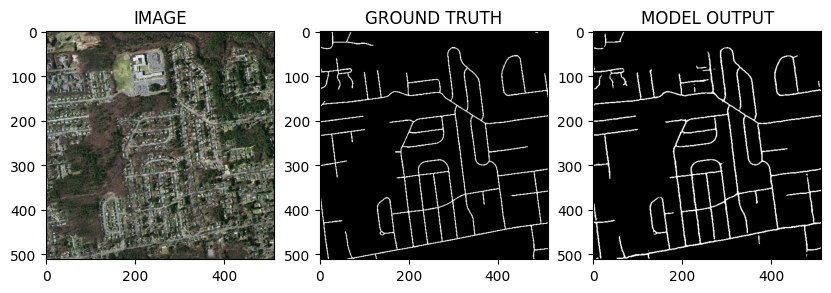

In [ ]:
show_image(image, mask, pred_mask.detach().cpu().squeeze(0))

In [ ]:
from torchvision import transforms
from PIL import Image
import torch.nn.functional as F

In [ ]:
print(model)


SegmentationModel(
  (backbone): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
      

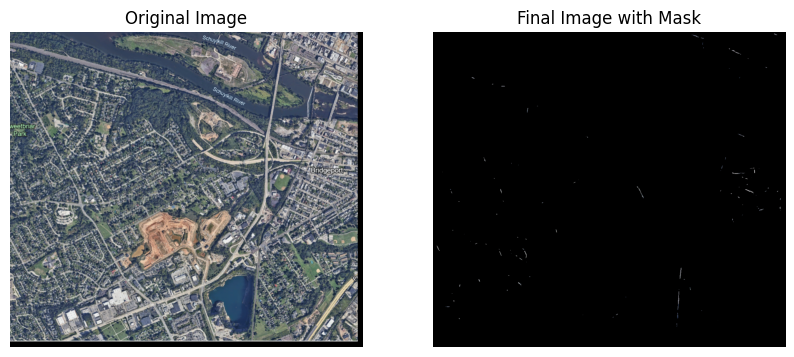

In [ ]:
# Define the transformation
transform = transforms.Compose([
    transforms.ToTensor(),
    # Add other transformations as needed
])

# Load the image and apply the transformation
dsg = '/content/Screenshot 2023-12-16 134106.png'
input_image = Image.open(dsg).convert('RGB')
input_image = transform(input_image)

# Pad the image to be divisible by 32
target_size = 32
h, w = input_image.shape[1:]
pad_h = (h // target_size + 1) * target_size - h
pad_w = (w // target_size + 1) * target_size - w
input_image = F.pad(input_image, (0, pad_w, 0, pad_h), mode='constant', value=0)

# Move to the appropriate device
input_image = input_image.unsqueeze(0).to(DEVICE)

# Make predictions
logits_mask = model(input_image)
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5).float()

# Convert the tensors to numpy arrays
input_image_np = input_image.squeeze(0).permute(1, 2, 0).cpu().numpy()
pred_mask_np = pred_mask.squeeze(0).cpu().numpy()

# Display the original and final images
plt.figure(figsize=(10, 5))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(input_image_np)
plt.title('Original Image')
plt.axis('off')

# Final image with predicted mask overlay
final_mask = pred_mask_np.squeeze(0)[:, :, None]  # Add an extra dimension for the third channel
final_image = input_image_np * final_mask
plt.subplot(1, 2, 2)
plt.imshow(final_image)
plt.title('Final Image with Mask')
plt.axis('off')

plt.show()